In [1]:
import requests
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import graphing

import plotly.express as px

import plotly.graph_objects as go


from datetime import datetime

from mpl_toolkits import mplot3d

import statsmodels.formula.api as smf
import missingno as msno
# from m1b_gradient_descent import gradient_descent
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_text

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

from sklearn.metrics import confusion_matrix, classification_report, log_loss, mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score

In [2]:
def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    response.raise_for_status()  # This will raise an exception for HTTP errors
    
    # Write the content to a file
    with open(filename, 'wb') as f:
        f.write(response.content)


In [3]:
#Import the data from the .csv file
dataset = pd.read_csv('avalanche.csv', delimiter="\t", index_col=0)

# Split our data into training and test
train, test = train_test_split(dataset, test_size=0.25, random_state=10)

print("Train size:", train.shape[0])
print("Test size:", test.shape[0])

#Let's have a look at the data
print(train.head())

Train size: 821
Test size: 274
     avalanche  no_visitors  surface_hoar  fresh_thickness  wind  weak_layers  \
176          0            9      5.142447         9.877195     6            8   
114          1            3      8.170281         9.136835    34            7   
869          0            3      1.979579         9.497017    10            8   
775          1            0      1.999078         9.337908    21            6   
181          1            9      6.854401         6.099359    22            5   

     tracked_out  
176            1  
114            0  
869            0  
775            0  
181            0  


We have numerous features available:

* `surface_hoar` is how disturbed the surface of the snow is
* `fresh_thickness` is how thick the top layer of snow is, or 0 if there's no fresh snow on top
* `wind` is the top wind speed that day, in km/h
* `weak_layers` is the number of layers of snow that aren't well-bound to other layers
* `no_visitors` is the number of hikers who were on the trail that day
* `tracked_out` is a `1` or `0`. A `1` means that the snow has been trampled heavily by hikers 

## Simple logistic regression

Let's make a simple logistic regression model and assess its performance with accuracy.



In [4]:
# Perform logistic regression.
model = smf.logit("avalanche ~ weak_layers", train).fit()

predictions = model.predict(test) 

# Calculate accuracy
def calculate_accuracy(model):
    '''
    Calculates accuracy
    '''
    # Make estimations and convert to categories
    avalanche_predicted = model.predict(test) > 0.5

    # Calculate what proportion were predicted correctly
    # We can use sklearn to calculate accuracy for us
    print("Accuracy:", accuracy_score(test.avalanche, avalanche_predicted))

calculate_accuracy(model)



Optimization terminated successfully.
         Current function value: 0.616312
         Iterations 5
Accuracy: 0.6167883211678832


In [5]:
threshold = 0.5
predictions = model.predict(test) > threshold

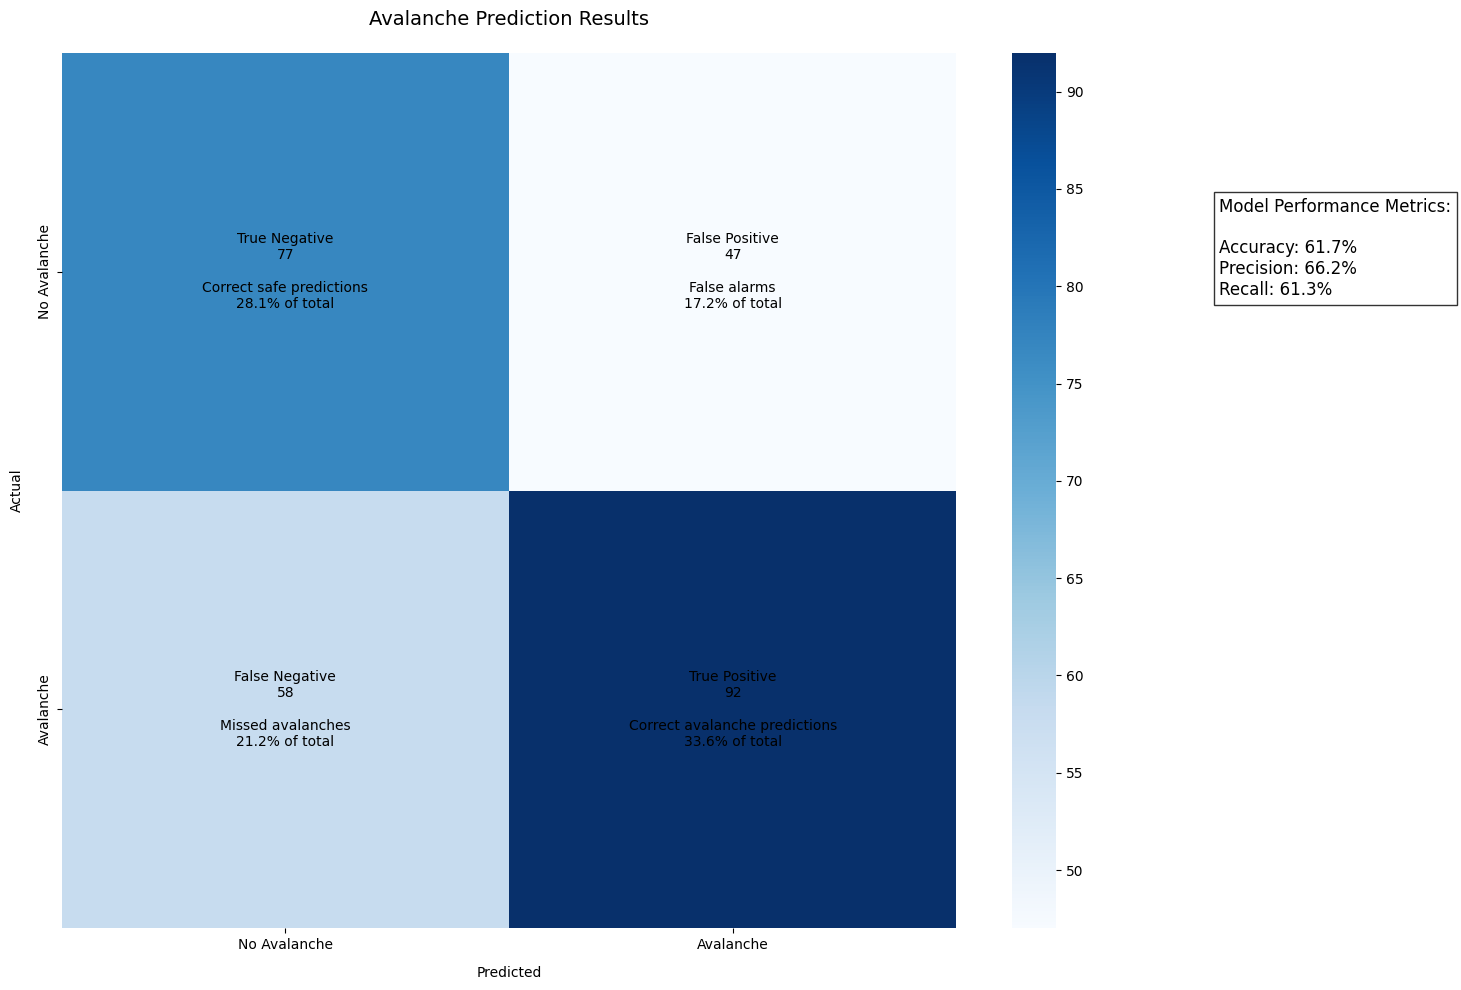

In [6]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.avalanche, predictions)

# Calculate metrics for display
total = np.sum(conf_matrix)
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / total
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

# Create figure with subplots - main plot for matrix, extra space for metrics
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(conf_matrix, 
            annot=False,
            cmap='Blues',
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'],
            ax=ax)

# Add detailed information to each cell
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        text = f'{labels[i][j]}\n{conf_matrix[i][j]}\n\n'
        if i == 0 and j == 0:  # True Negatives
            text += f'Correct safe predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 0 and j == 1:  # False Positives
            text += f'False alarms\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 1 and j == 0:  # False Negatives
            text += f'Missed avalanches\n{(conf_matrix[i][j]/total):,.1%} of total'
        else:  # True Positives
            text += f'Correct avalanche predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
            
        ax.text(j + 0.5, i + 0.5, text,
                ha='center',
                va='center')

# Add metrics as text box in the figure
metrics_text = (f'Model Performance Metrics:\n\n'
               f'Accuracy: {accuracy:.1%}\n'
               f'Precision: {precision:.1%}\n'
               f'Recall: {recall:.1%}')

plt.figtext(1.02, 0.7, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12)

# Set titles and labels
plt.title('Avalanche Prediction Results', pad=20, fontsize=14)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)

# Adjust layout to make room for metrics
plt.tight_layout()

# Show the plot
plt.show()

Let's see how we can improve our model

## Utilizing multiple features

Most of our features seem like they could be useful, least in theory. Let's try a model with all features we've available.

In [7]:
# Perform logistic regression.
model_all_features = smf.logit("avalanche ~ weak_layers + surface_hoar + fresh_thickness + wind + no_visitors + tracked_out", train).fit()
calculate_accuracy(model_all_features)

model_all_features.summary()

Optimization terminated successfully.
         Current function value: 0.459347
         Iterations 7
Accuracy: 0.7846715328467153


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            6
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                  0.3305
Time:                        22:29:26   Log-Likelihood:                -377.12
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 2.372e-77
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.0107      0.443     -9.043      0.000      -4.880      -3.141
weak_layers         0.3733      0.034     10.871      0.000       0.306       0.441
surface_hoar        0.3306      0.035      9.424      0.000       0.262       0.399
fresh_thickness    -0.0220      0.030     -0.732      0.464      -0.081       0.037
wind                0.1009      0.009     11.149      0.000       0.083       0.119
no_visitors        -0.1060      0.032     -3.262      0.001      -0.170      -0.042
tracked_out        -0.0664      0.181     -0.367      0.713      -0.420       0.288
===================================================================================
"""

In [8]:
threshold = 0.5
predictions = model_all_features.predict(test) > threshold

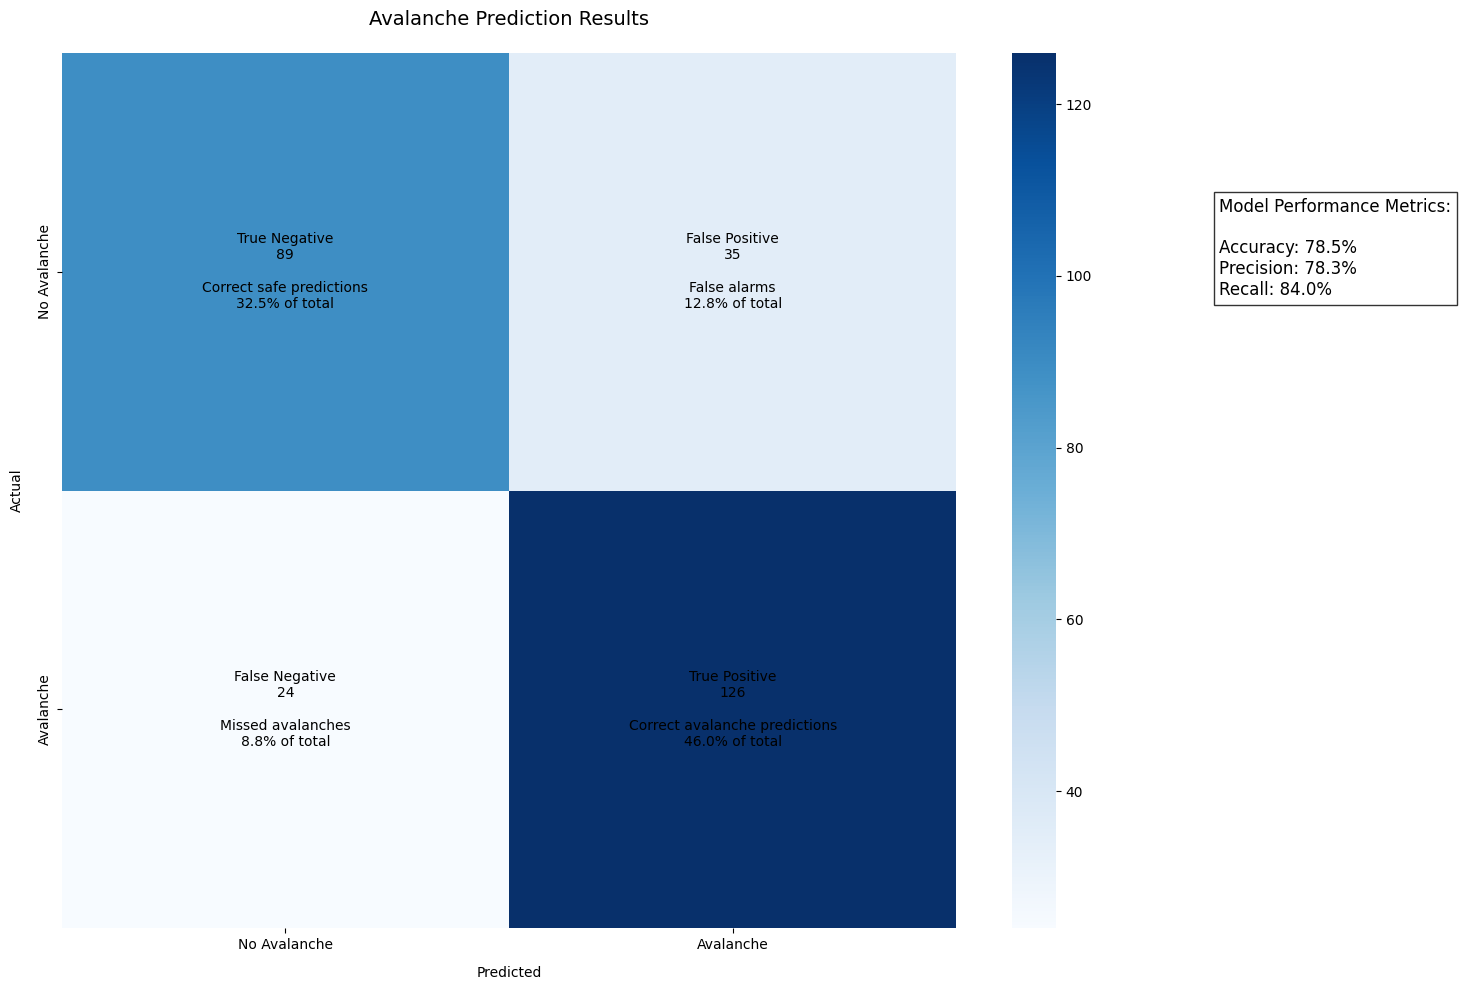

In [9]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.avalanche, predictions)

# Calculate metrics for display
total = np.sum(conf_matrix)
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / total
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

# Create figure with subplots - main plot for matrix, extra space for metrics
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(conf_matrix, 
            annot=False,
            cmap='Blues',
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'],
            ax=ax)

# Add detailed information to each cell
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        text = f'{labels[i][j]}\n{conf_matrix[i][j]}\n\n'
        if i == 0 and j == 0:  # True Negatives
            text += f'Correct safe predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 0 and j == 1:  # False Positives
            text += f'False alarms\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 1 and j == 0:  # False Negatives
            text += f'Missed avalanches\n{(conf_matrix[i][j]/total):,.1%} of total'
        else:  # True Positives
            text += f'Correct avalanche predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
            
        ax.text(j + 0.5, i + 0.5, text,
                ha='center',
                va='center')

# Add metrics as text box in the figure
metrics_text = (f'Model Performance Metrics:\n\n'
               f'Accuracy: {accuracy:.1%}\n'
               f'Precision: {precision:.1%}\n'
               f'Recall: {recall:.1%}')

plt.figtext(1.02, 0.7, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12)

# Set titles and labels
plt.title('Avalanche Prediction Results', pad=20, fontsize=14)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)

# Adjust layout to make room for metrics
plt.tight_layout()

# Show the plot
plt.show()

Take a look at the P column, recalling that values less than 0.05 mean we can be confident that this parameter is helping the model make better predictions.

Both `surface_hoar` and `wind` have very small values here, meaning they're useful predictors and probably explain why our model is working better. If we look at the `coef` (which states _parameters_) column we see that these have positive values. This means that higher winds, and greater amounts of surface hoar result in higher avalanche risk.

## Simplifying our model

Looking at the summary again, we can see that `tracked_out` (how trampled the snow is), and `fresh_thickness` have large p-values. This means they aren't useful predictors. Let's see what happens if we remove them from our model:

In [10]:
# Perform logistic regression.
model_simplified = smf.logit("avalanche ~ weak_layers + surface_hoar + wind + no_visitors", train).fit()
calculate_accuracy(model_simplified)

Optimization terminated successfully.
         Current function value: 0.459760
         Iterations 7
Accuracy: 0.781021897810219


In [13]:
model_simplified.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      816
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                  0.3299
Time:                        22:38:33   Log-Likelihood:                -377.46
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 3.552e-79
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.2191      0.366    -11.535      0.000      -4.936      -3.502
weak_layers      0.3738      0.034     10.882      0.000       0.306       0.441
surface_hoar     0.3303      0.035      9.423      0.000       0.262       0.399
wind             0.1007      0.009     11.166      0.000       0.083       0.118
no_visitors     -0.1053      0.032     -3.249      0.001      -0.169      -0.042
================================================================================
"""

In [11]:
threshold = 0.5
predictions = model_simplified.predict(test) > threshold

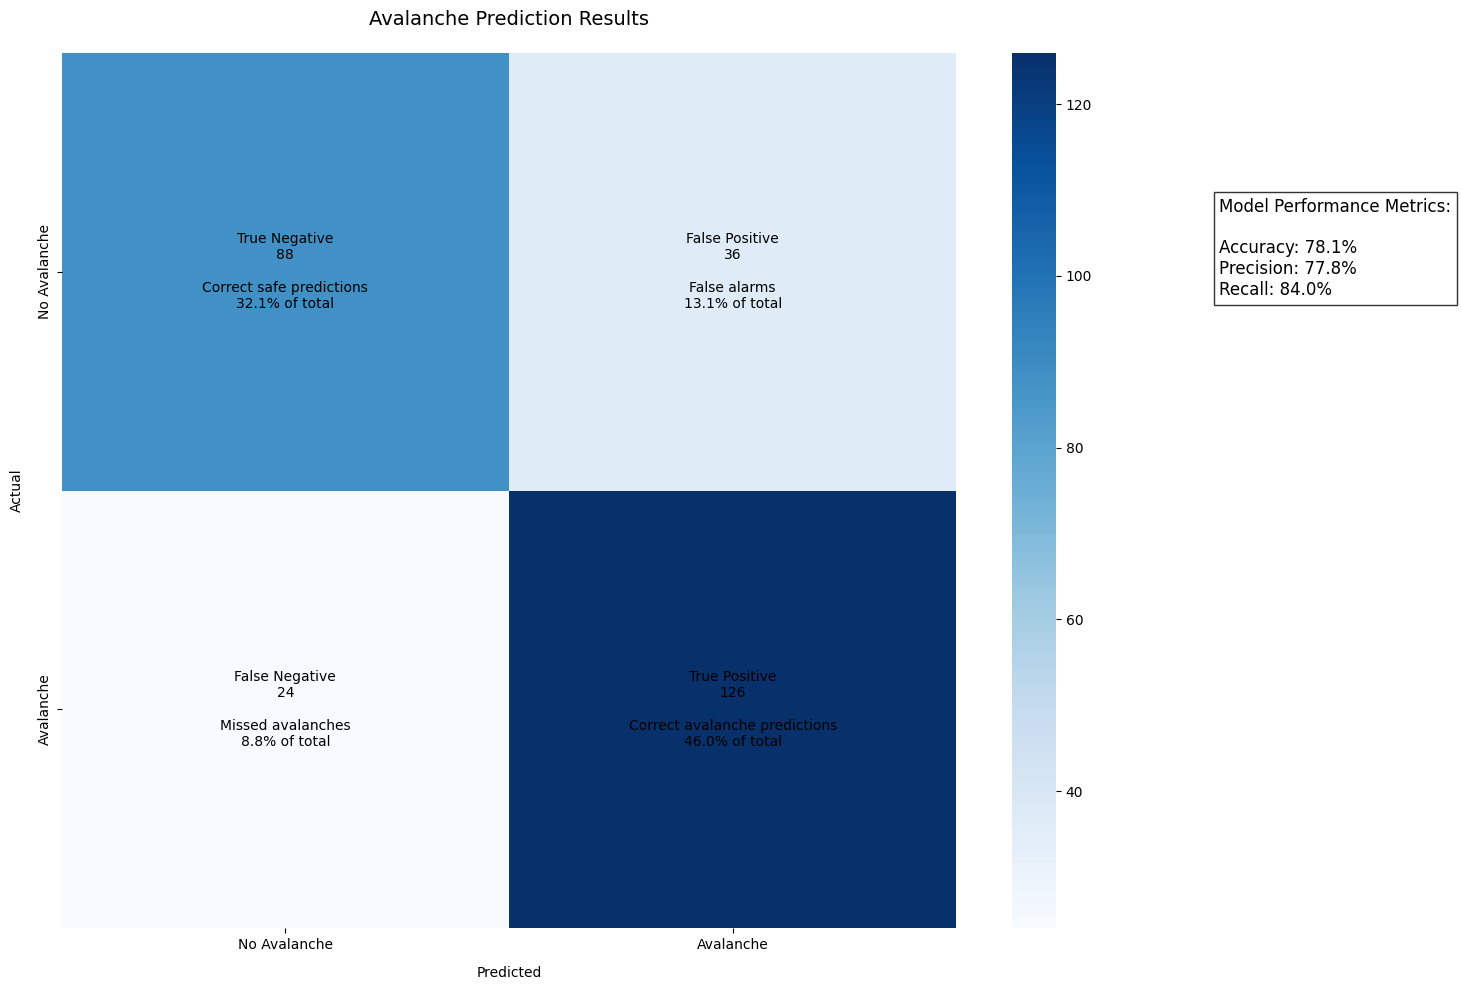

In [12]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.avalanche, predictions)

# Calculate metrics for display
total = np.sum(conf_matrix)
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / total
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

# Create figure with subplots - main plot for matrix, extra space for metrics
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(conf_matrix, 
            annot=False,
            cmap='Blues',
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'],
            ax=ax)

# Add detailed information to each cell
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        text = f'{labels[i][j]}\n{conf_matrix[i][j]}\n\n'
        if i == 0 and j == 0:  # True Negatives
            text += f'Correct safe predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 0 and j == 1:  # False Positives
            text += f'False alarms\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 1 and j == 0:  # False Negatives
            text += f'Missed avalanches\n{(conf_matrix[i][j]/total):,.1%} of total'
        else:  # True Positives
            text += f'Correct avalanche predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
            
        ax.text(j + 0.5, i + 0.5, text,
                ha='center',
                va='center')

# Add metrics as text box in the figure
metrics_text = (f'Model Performance Metrics:\n\n'
               f'Accuracy: {accuracy:.1%}\n'
               f'Precision: {precision:.1%}\n'
               f'Recall: {recall:.1%}')

plt.figtext(1.02, 0.7, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12)

# Set titles and labels
plt.title('Avalanche Prediction Results', pad=20, fontsize=14)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)

# Adjust layout to make room for metrics
plt.tight_layout()

# Show the plot
plt.show()

Look at the `fresh_thickness` row. We're told that it has a negative coefficient. This means that as thickness increases, avalanches decrease.

Similarly, `no_visitors` has a negative coefficient, meaning that fewer hikers means more avalanches.

How can this be? Well, while visitors can cause avalanches if there's a lot of fresh snow, presumably they cannot do so easily if there's no fresh snow. This means that our features aren't fully independent.

We can tell the model to try to take into account that these features interact, using a multiply sign. Let's try that now.

In [14]:
# Create a model with an interaction. Notice the end of the string where
# we've a multiply sign between no_visitors and fresh_thickness
formula = "avalanche ~ weak_layers + surface_hoar + wind + no_visitors * fresh_thickness"
model_with_interaction = smf.logit(formula, train).fit()
calculate_accuracy(model_with_interaction)

Optimization terminated successfully.
         Current function value: 0.413538
         Iterations 7
Accuracy: 0.8357664233576643


In [15]:
model_with_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              avalanche   No. Observations:                  821
Model:                          Logit   Df Residuals:                      814
Method:                           MLE   Df Model:                            6
Date:                Wed, 08 Jan 2025   Pseudo R-squ.:                  0.3973
Time:                        22:39:53   Log-Likelihood:                -339.51
converged:                       True   LL-Null:                       -563.33
Covariance Type:            nonrobust   LLR p-value:                 1.587e-93
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.9606      0.587     -1.636      0.102      -2.111       0.190
weak_layers                     0.4327      0.039     11.193      0.000       0.357       0.508
surface_hoar                    0.3887      0.039     10.035      0.000       0.313       0.465
wind                            0.1204      0.010     11.607      0.000       0.100       0.141
no_visitors                    -0.9430      0.114     -8.237      0.000      -1.167      -0.719
fresh_thickness                -0.4962      0.069     -7.191      0.000      -0.631      -0.361
no_visitors:fresh_thickness     0.1015      0.013      7.835      0.000       0.076       0.127
===============================================================================================
"""

In [16]:
threshold = 0.5
predictions = model_simplified.predict(test) > threshold

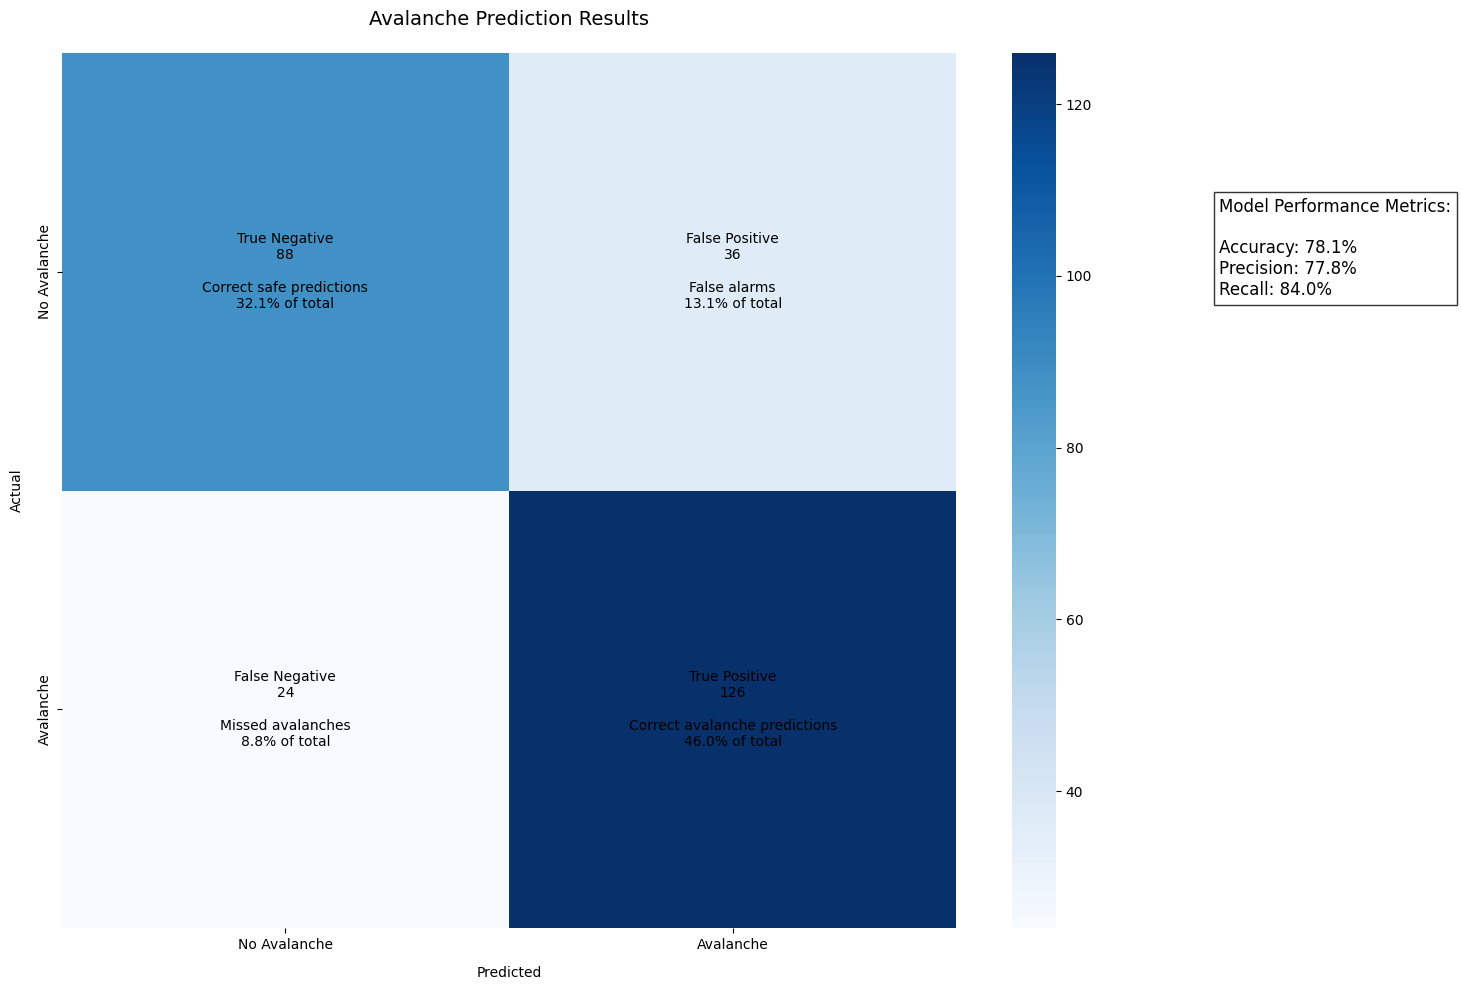

In [17]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.avalanche, predictions)

# Calculate metrics for display
total = np.sum(conf_matrix)
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / total
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

# Create figure with subplots - main plot for matrix, extra space for metrics
fig, ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(conf_matrix, 
            annot=False,
            cmap='Blues',
            xticklabels=['No Avalanche', 'Avalanche'],
            yticklabels=['No Avalanche', 'Avalanche'],
            ax=ax)

# Add detailed information to each cell
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

for i in range(2):
    for j in range(2):
        text = f'{labels[i][j]}\n{conf_matrix[i][j]}\n\n'
        if i == 0 and j == 0:  # True Negatives
            text += f'Correct safe predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 0 and j == 1:  # False Positives
            text += f'False alarms\n{(conf_matrix[i][j]/total):,.1%} of total'
        elif i == 1 and j == 0:  # False Negatives
            text += f'Missed avalanches\n{(conf_matrix[i][j]/total):,.1%} of total'
        else:  # True Positives
            text += f'Correct avalanche predictions\n{(conf_matrix[i][j]/total):,.1%} of total'
            
        ax.text(j + 0.5, i + 0.5, text,
                ha='center',
                va='center')

# Add metrics as text box in the figure
metrics_text = (f'Model Performance Metrics:\n\n'
               f'Accuracy: {accuracy:.1%}\n'
               f'Precision: {precision:.1%}\n'
               f'Recall: {recall:.1%}')

plt.figtext(1.02, 0.7, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=12)

# Set titles and labels
plt.title('Avalanche Prediction Results', pad=20, fontsize=14)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)

# Adjust layout to make room for metrics
plt.tight_layout()

# Show the plot
plt.show()

We can see that the interaction term is helpful - the p-value is less than 0.05. The model is also performing better than our previous attempts.

## Making predictions with multiple features

Very quickly, lets explore what this interaction means by looking at model predictions. 

We will first graph two independent features in 3D. Let's start with `weak_layers` and `wind`:

In [18]:
graphing.model_to_surface_plot(model_with_interaction, ["weak_layers", "wind"], test)

Creating plot...


c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z[i_y, i_x] = calc_z(x_values[i_x], y_values[i_y])
c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z[i_y, i_x] = calc_z(x_values[i_x], y_values[i_y])
c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z[i_y, i_x] = calc_z(x_values[i_x], y_values[i_y])
c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeE

The graph is interactive - rotate it and explore how there's a clear s-shaped relationship between the features and probability.

Let's now look at the features that we've said can interact:

In [19]:
graphing.model_to_surface_plot(model_with_interaction, ["no_visitors", "fresh_thickness"], test)

Creating plot...


c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

c:\Users\danja\python_projects\dp_100_azure\1_8_classification\graphing.py:490: FutureWarning:

Call